# Graphs = Actions orchestration

### States

In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

In [2]:
def node_1(state):
    print("--- Node 1 ---")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state):
    print("--- Node 2 ---")
    return {"graph_state": state['graph_state'] +" happy :)"}

def node_3(state):
    print("--- Node 3 ---")
    return {"graph_state": state['graph_state'] +" sad :("}

In [4]:
import random
from typing import Literal

def mood_check(state) -> Literal["Node2", "Node3"]:

    user_input = state['graph_state']

    if random.random() < 0.5:
        return "Node2"

    return "Node3"

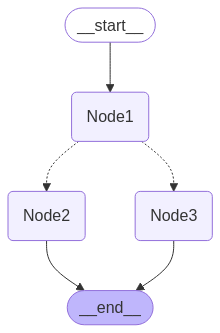

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Węzły
builder = StateGraph(State)
builder.add_node("Node1", node_1)
builder.add_node("Node2", node_2)
builder.add_node("Node3", node_3)

# Logika
builder.add_edge(START, "Node1")
builder.add_conditional_edges("Node1", mood_check)
builder.add_edge("Node2", END)
builder.add_edge("Node3", END)

# Kompilacja
graph = builder.compile()

# Wizualizacja
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
graph.invoke({"graph_state" : "We meet again"})

--- Node 1 ---
--- Node 2 ---


{'graph_state': 'We meet again I am happy :)'}

### LLM as a component

In [11]:
from dotenv import load_dotenv
load_dotenv()

True

In [12]:
from langchain_openai import ChatOpenAI
import os

llm = ChatOpenAI(api_key=os.environ["OPENAI_API_KEY"], model="gpt-4o-mini")

In [13]:
from typing import Annotated
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

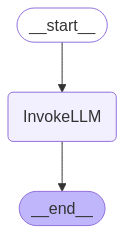

In [17]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Node
def invoke_llm(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("InvokeLLM", invoke_llm)
builder.add_edge(START, "InvokeLLM")
builder.add_edge("InvokeLLM", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
graph.invoke({"messages" : HumanMessage(content="We meet again")})

{'messages': [HumanMessage(content='We meet again', additional_kwargs={}, response_metadata={}, id='5d8c9418-c85c-4ff7-9d1d-fd6decfdf86a'),
  AIMessage(content="Hello again! It's great to see you. What would you like to talk about today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 10, 'total_tokens': 29, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BO5lSJ3G0tA9wUswZo4oqm5LxBpeQ', 'finish_reason': 'stop', 'logprobs': None}, id='run-d025ecd9-05dd-4930-a607-7026bab10d3e-0', usage_metadata={'input_tokens': 10, 'output_tokens': 19, 'total_tokens': 29, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

### LLM With tools

In [19]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
tool_aware_llm = llm.bind_tools(tools)

In [20]:
from typing import Annotated
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

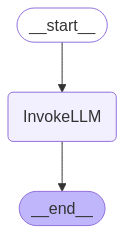

In [21]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Node
def invoke_llm_with_tools(state: MessagesState):
    return {"messages": [tool_aware_llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("llm_with_tools", invoke_llm_with_tools)
builder.add_edge(START, "llm_with_tools")
builder.add_edge("llm_with_tools", END)
graph_with_tools = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
question = "What is current president of USA?"

messages = graph_with_tools.invoke({"messages": HumanMessage(content=question)})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is current president of USA?
================================== Ai Message ==================================

As of my last knowledge update in October 2023, the President of the United States is Joe Biden. He took office on January 20, 2021. Please verify with current news sources for the most up-to-date information.


### Another test

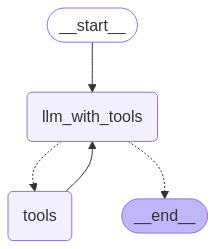

In [23]:
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode

from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


sys_msg = SystemMessage(content="You are a helpful math assistant")

def invoke_llm_with_tools(state: MessagesState):
    return {"messages": [tool_aware_llm.invoke([sys_msg] + state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("llm_with_tools", invoke_llm_with_tools)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "llm_with_tools")
builder.add_conditional_edges(
    "llm_with_tools",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "llm_with_tools")

graph_with_tool_executor = builder.compile()

# View
display(Image(graph_with_tool_executor.get_graph().draw_mermaid_png()))

In [24]:
messages = [HumanMessage(content="Add three and four")]
messages = graph_with_tool_executor.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add three and four
================================== Ai Message ==================================
Tool Calls:
  add (call_y8iTEfO2TJGv4HyKHY9QDzc0)
 Call ID: call_y8iTEfO2TJGv4HyKHY9QDzc0
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of three and four is seven.


In [25]:
messages = [HumanMessage(content="Dodaj 3 do 4, potem przemnóż to przez pięć, a na koniec podziel przez 8")]
messages = graph_with_tool_executor.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Dodaj 3 do 4, potem przemnóż to przez pięć, a na koniec podziel przez 8
================================== Ai Message ==================================
Tool Calls:
  add (call_m3HHRieK0Snv2MlIXyPiMZ88)
 Call ID: call_m3HHRieK0Snv2MlIXyPiMZ88
  Args:
    a: 3
    b: 4
  multiply (call_sJRiW2RVBUvbt2EGtPYCUraX)
 Call ID: call_sJRiW2RVBUvbt2EGtPYCUraX
  Args:
    a: 5
    b: 5
  divide (call_ZLCFJ9b2N6nKHtRN3O6WZzpd)
 Call ID: call_ZLCFJ9b2N6nKHtRN3O6WZzpd
  Args:
    a: 8
    b: 8
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: multiply

25
================================= Tool Message =================================
Name: divide

1.0
================================== Ai Message ==================================
Tool Calls:
  multiply (call_HX6s8bcLiSbhTQ3pVmkcrKna)
 Cal